In [1]:
import pandas as pd
import numpy as np
import os
from glob import glob
import random
import matplotlib.pylab as plt
import keras.backend as K
from sklearn.model_selection import train_test_split
import tensorflow as tf
import keras
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from tensorflow.keras.optimizers import SGD, RMSprop, Adam, Adagrad, Adadelta
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, Conv2D, MaxPool2D, MaxPooling2D
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow.keras.applications import VGG16
%matplotlib inline

In [2]:
# Detect hardware, return appropriate distribution strategy
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy() # default distribution strategy in Tensorflow. Works on CPU and single GPU.

print("REPLICAS: ", strategy.num_replicas_in_sync)

REPLICAS:  1


In [3]:
imagePatches = glob('../input/breast-histopathology-images/IDC_regular_ps50_idx5/**/*.png', recursive=True)
for filename in imagePatches[0:10]:
    print(filename)

../input/breast-histopathology-images/IDC_regular_ps50_idx5/10295/0/10295_idx5_x1351_y1101_class0.png
../input/breast-histopathology-images/IDC_regular_ps50_idx5/10295/0/10295_idx5_x1501_y501_class0.png
../input/breast-histopathology-images/IDC_regular_ps50_idx5/10295/0/10295_idx5_x1501_y1101_class0.png
../input/breast-histopathology-images/IDC_regular_ps50_idx5/10295/0/10295_idx5_x451_y901_class0.png
../input/breast-histopathology-images/IDC_regular_ps50_idx5/10295/0/10295_idx5_x801_y451_class0.png
../input/breast-histopathology-images/IDC_regular_ps50_idx5/10295/0/10295_idx5_x151_y1051_class0.png
../input/breast-histopathology-images/IDC_regular_ps50_idx5/10295/0/10295_idx5_x1351_y901_class0.png
../input/breast-histopathology-images/IDC_regular_ps50_idx5/10295/0/10295_idx5_x701_y651_class0.png
../input/breast-histopathology-images/IDC_regular_ps50_idx5/10295/0/10295_idx5_x951_y1401_class0.png
../input/breast-histopathology-images/IDC_regular_ps50_idx5/10295/0/10295_idx5_x601_y501_cla

In [4]:
# Two arrays holding images by class type

class0 = [] # 0 = no cancer
class1 = [] # 1 = cancer

for filename in imagePatches:
    if filename.endswith("class0.png"):
         class0.append(filename)
    else:
        class1.append(filename)

In [5]:
len(class1)

78786

In [6]:
sampled_class0 = random.sample(class0, 78786)
sampled_class1 = random.sample(class1, 78786)
len(sampled_class0)

78786

In [7]:
from matplotlib.image import imread
import cv2

def get_image_arrays(data, label):
    img_arrays = []
    for i in data:
        if i.endswith('.png'):
            img = cv2.imread(i ,cv2.IMREAD_COLOR)
            img_sized = cv2.resize(img, (75, 75), interpolation=cv2.INTER_LINEAR)
            img_arrays.append([img_sized, label])
    return img_arrays

In [8]:
class0_array = get_image_arrays(sampled_class0, 0)
class1_array = get_image_arrays(sampled_class1, 1)

In [9]:
class0_array[1]

[array([[[205, 188, 236],
         [208, 192, 234],
         [212, 196, 232],
         ...,
         [211, 193, 235],
         [210, 191, 234],
         [208, 189, 233]],
 
        [[201, 179, 231],
         [202, 181, 231],
         [204, 184, 232],
         ...,
         [211, 191, 233],
         [209, 189, 233],
         [206, 185, 232]],
 
        [[196, 170, 225],
         [195, 170, 228],
         [196, 171, 230],
         ...,
         [207, 185, 231],
         [205, 183, 230],
         [202, 180, 229]],
 
        ...,
 
        [[178, 147, 201],
         [190, 163, 214],
         [202, 180, 228],
         ...,
         [189, 166, 225],
         [199, 178, 228],
         [207, 186, 230]],
 
        [[169, 138, 189],
         [180, 151, 206],
         [193, 167, 224],
         ...,
         [180, 153, 221],
         [188, 161, 223],
         [194, 168, 224]],
 
        [[165, 137, 183],
         [170, 140, 201],
         [178, 147, 220],
         ...,
         [174, 140, 218],
  

In [10]:
test = cv2.imread('../input/breast-histopathology-images/IDC_regular_ps50_idx5/13689/1/13689_idx5_x801_y1501_class1.png' ,cv2.IMREAD_COLOR)
test.shape

(50, 50, 3)

In [11]:
combined_data = np.concatenate((class0_array, class1_array))
random.seed(41)
random.shuffle(combined_data)

<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [12]:
X = []
y = []

for features,label in combined_data:
    X.append(features)
    y.append(label)

In [13]:
# print(X[11].reshape(-1, 50, 50, 3))
# reshape X data
X = np.array(X).reshape(-1, 75, 75, 3)

In [14]:
X.shape

(157572, 75, 75, 3)

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(118179, 75, 75, 3) (39393, 75, 75, 3) (118179, 2) (39393, 2)


In [16]:
from tensorflow.keras.applications import InceptionV3

In [17]:
base_model = tf.keras.applications.InceptionV3(input_shape=(75,75,3),include_top=False,weights="imagenet")

2021-12-30 19:32:11.874543: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-30 19:32:11.968019: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-30 19:32:11.968730: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-30 19:32:11.969923: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

87924736/87910968 [==============================] - 2s 0us/step


node zero
2021-12-30 19:32:11.971710: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-30 19:32:11.972340: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-30 19:32:13.746027: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-30 19:32:13.746838: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-30 19:32:13.747531: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node r

In [18]:
# Freezing Layers

for layer in base_model.layers[:-5]:
    layer.trainable=False

In [19]:
# Building Model

model=Sequential()
model.add(base_model)
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(2,activation='softmax'))

In [20]:
# Model Summary

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 1, 1, 2048)        21802784  
_________________________________________________________________
dropout (Dropout)            (None, 1, 1, 2048)        0         
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 2)                 4098      
Total params: 21,806,882
Trainable params: 4,098
Non-trainable params: 21,802,784
_________________________________________________________________


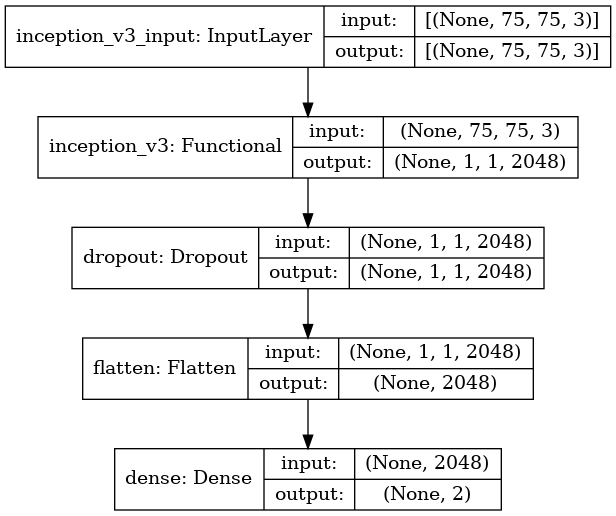

In [21]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image
plot_model(model, to_file='convnet.png', show_shapes=True,show_layer_names=True)
Image(filename='convnet.png') 

In [22]:
def f1_score(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [23]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),  
      tf.keras.metrics.AUC(name='auc'),
        f1_score,
]

In [24]:
lrd = ReduceLROnPlateau(monitor = 'val_loss',patience = 5,verbose = 1,factor = 0.75, min_lr = 1e-10)

mcp = ModelCheckpoint('model.h5')

es = EarlyStopping(verbose=1, patience=5)

In [25]:
model.compile(optimizer='Adam', loss='binary_crossentropy',metrics=METRICS)

In [26]:
%time
history=model.fit(X_train, y_train,validation_data=(X_test, y_test),verbose = 1,epochs = 8,callbacks=[lrd,mcp,es])

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 6.2 µs


2021-12-30 19:32:20.481413: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1994270625 exceeds 10% of free system memory.
2021-12-30 19:32:23.219263: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1994270625 exceeds 10% of free system memory.
2021-12-30 19:32:24.719555: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/8


2021-12-30 19:32:29.905917: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


3694/3694 [==============================] - ETA: 0s - loss: 3.5774 - accuracy: 0.7998 - precision: 0.7998 - recall: 0.7998 - auc: 0.8192 - f1_score: 0.7997

2021-12-30 19:34:03.226827: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 664756875 exceeds 10% of free system memory.
2021-12-30 19:34:04.398818: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 664756875 exceeds 10% of free system memory.


3694/3694 [==============================] - 126s 31ms/step - loss: 3.5774 - accuracy: 0.7998 - precision: 0.7998 - recall: 0.7998 - auc: 0.8192 - f1_score: 0.7997 - val_loss: 1.1380 - val_accuracy: 0.8524 - val_precision: 0.8524 - val_recall: 0.8524 - val_auc: 0.8752 - val_f1_score: 0.8526
Epoch 2/8
3694/3694 [==============================] - 111s 30ms/step - loss: 2.3540 - accuracy: 0.7951 - precision: 0.7951 - recall: 0.7951 - auc: 0.8183 - f1_score: 0.7951 - val_loss: 2.8022 - val_accuracy: 0.8458 - val_precision: 0.8458 - val_recall: 0.8458 - val_auc: 0.8480 - val_f1_score: 0.8459
Epoch 3/8
3694/3694 [==============================] - 111s 30ms/step - loss: 2.3038 - accuracy: 0.7960 - precision: 0.7960 - recall: 0.7960 - auc: 0.8188 - f1_score: 0.7960 - val_loss: 1.6496 - val_accuracy: 0.8474 - val_precision: 0.8474 - val_recall: 0.8474 - val_auc: 0.8601 - val_f1_score: 0.8475
Epoch 4/8
3694/3694 [==============================] - 111s 30ms/step - loss: 2.3532 - accuracy: 0.7956 

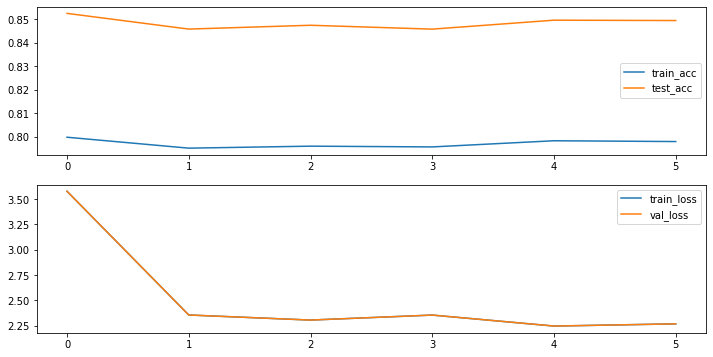

In [27]:
#plot the accuracy graph
plt.figure(figsize = (12,6))
plt.subplot(2,1,1)
plt.plot(history.history['accuracy'], label="train_acc")
plt.plot(history.history['val_accuracy'], label = "test_acc")
plt.legend()
plt.subplot(2,1,2)
plt.plot(history.history['loss'], label = "train_loss")
plt.plot(history.history['loss'], label = "val_loss")
plt.legend()

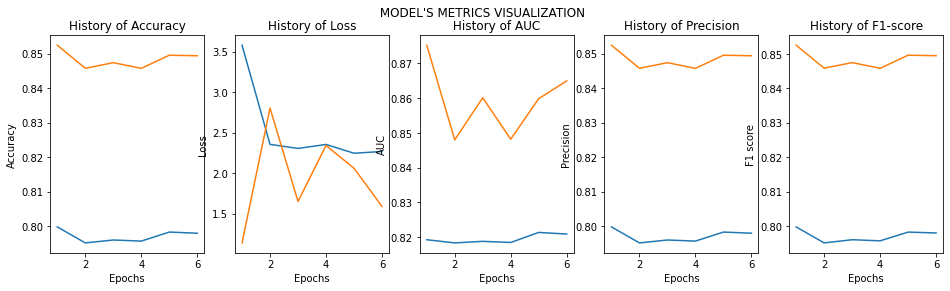

In [28]:
#%% PLOTTING RESULTS (Train vs Validation FOLDER 1)

def Train_Val_Plot(acc,val_acc,loss,val_loss,auc,val_auc,precision,val_precision,f1,val_f1):
    
    fig, (ax1, ax2,ax3,ax4,ax5) = plt.subplots(1,5, figsize= (16,4))
    fig.suptitle(" MODEL'S METRICS VISUALIZATION ")

    ax1.plot(range(1, len(acc) + 1), acc)
    ax1.plot(range(1, len(val_acc) + 1), val_acc)
    ax1.set_title('History of Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    #ax1.legend(['training', 'validation'])


    ax2.plot(range(1, len(loss) + 1), loss)
    ax2.plot(range(1, len(val_loss) + 1), val_loss)
    ax2.set_title('History of Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    #ax2.legend(['training', 'validation'])
    
    ax3.plot(range(1, len(auc) + 1), auc)
    ax3.plot(range(1, len(val_auc) + 1), val_auc)
    ax3.set_title(' History of AUC ')
    ax3.set_xlabel(' Epochs ')
    ax3.set_ylabel('AUC')
    #ax3.legend(['training', 'validation'])
    
    ax4.plot(range(1, len(precision) + 1), precision)
    ax4.plot(range(1, len(val_precision) + 1), val_precision)
    ax4.set_title('History of Precision')
    ax4.set_xlabel('Epochs')
    ax4.set_ylabel('Precision')
    #ax4.legend(['training', 'validation'])
    
    ax5.plot(range(1, len(f1) + 1), f1)
    ax5.plot(range(1, len(val_f1) + 1), val_f1)
    ax5.set_title('History of F1-score')
    ax5.set_xlabel('Epochs')
    ax5.set_ylabel('F1 score')
    #ax5.legend(['training', 'validation'])


    plt.show()
    

Train_Val_Plot(history.history['accuracy'],history.history['val_accuracy'],
               history.history['loss'],history.history['val_loss'],
               history.history['auc'],history.history['val_auc'],
               history.history['precision'],history.history['val_precision'],
               history.history['f1_score'],history.history['val_f1_score']
              )

2021-12-30 19:43:52.116402: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 664756875 exceeds 10% of free system memory.


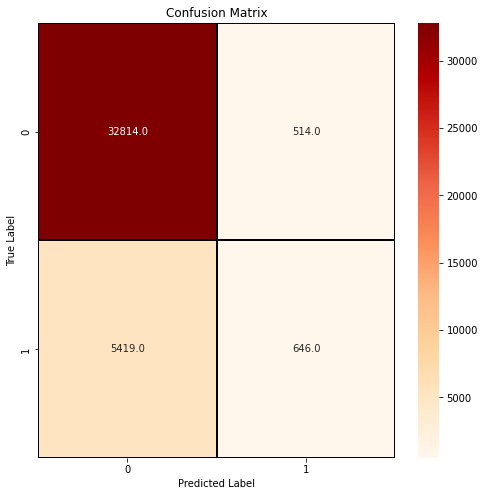

In [29]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

Y_pred = model.predict(X_test)
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
Y_true = np.argmax(y_test,axis = 1) 

confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 

f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="OrRd",linecolor="black", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [30]:
from sklearn.metrics import classification_report

print(classification_report(Y_true, Y_pred_classes))

              precision    recall  f1-score   support

           0       0.86      0.98      0.92     33328
           1       0.56      0.11      0.18      6065

    accuracy                           0.85     39393
   macro avg       0.71      0.55      0.55     39393
weighted avg       0.81      0.85      0.80     39393



In [31]:
#save model
# loading dependency
from sklearn.externals import joblib

ImportError: cannot import name 'joblib' from 'sklearn.externals' (/opt/conda/lib/python3.7/site-packages/sklearn/externals/__init__.py)

In [ ]:
# saving our model # model - model , filename-model_jlib
joblib.dump(model , 'model_jlib')